In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv('NIFTY 50.csv', parse_dates=['Date'])
data = data.sort_values('Date')

# Calculate daily returns
data['Return'] = data['Close'].pct_change()
data = data.dropna()

# Discretize returns into 3 states: -1 (down), 0 (neutral), 1 (up)
data['State'] = pd.cut(data['Return'], bins=[-np.inf, -0.005, 0.005, np.inf], labels=[-1, 0, 1])
states = data['State'].values
unique_states = [-1, 0, 1]

# Model Parameters

In [3]:
# Number of hidden states
N = 2
hidden_states = ['Bullish', 'Bearish']

# Initial state probabilities (pi)
pi = np.array([0.5, 0.5])  # Equal probability to start in either state

# Transition matrix (A)
A = np.array([[0.7, 0.3],   # Bullish to Bullish, Bullish to Bearish
              [0.4, 0.6]])  # Bearish to Bullish, Bearish to Bearish

# Emission probabilities (B)
# Probability of observing each state (-1, 0, 1) given hidden state
B = np.array([[0.2, 0.6, 0.2],   # Bullish market emission probabilities
              [0.5, 0.3, 0.2]])  # Bearish market emission probabilities

# Forward Algorithm

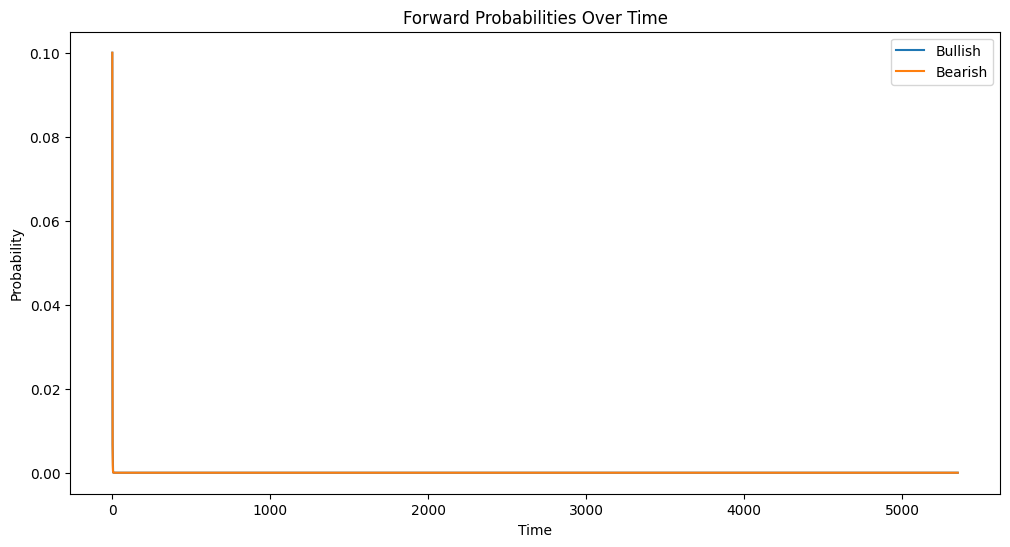

In [4]:
def forward_algorithm(observations, pi, A, B):
    T = len(observations)
    alpha = np.zeros((T, N))
    
    # Initialize first step
    obs_idx = unique_states.index(observations[0])
    alpha[0, :] = pi * B[:, obs_idx]
    
    # Iterate through the observations
    for t in range(1, T):
        obs_idx = unique_states.index(observations[t])
        for j in range(N):
            alpha[t, j] = np.sum(alpha[t-1, :] * A[:, j]) * B[j, obs_idx]
    
    return alpha

# Run forward algorithm
alpha = forward_algorithm(states, pi, A, B)

# Plot the forward probabilities
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(alpha[:, i], label=f'{hidden_states[i]}')
plt.title('Forward Probabilities Over Time')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

# Backward Algorithm

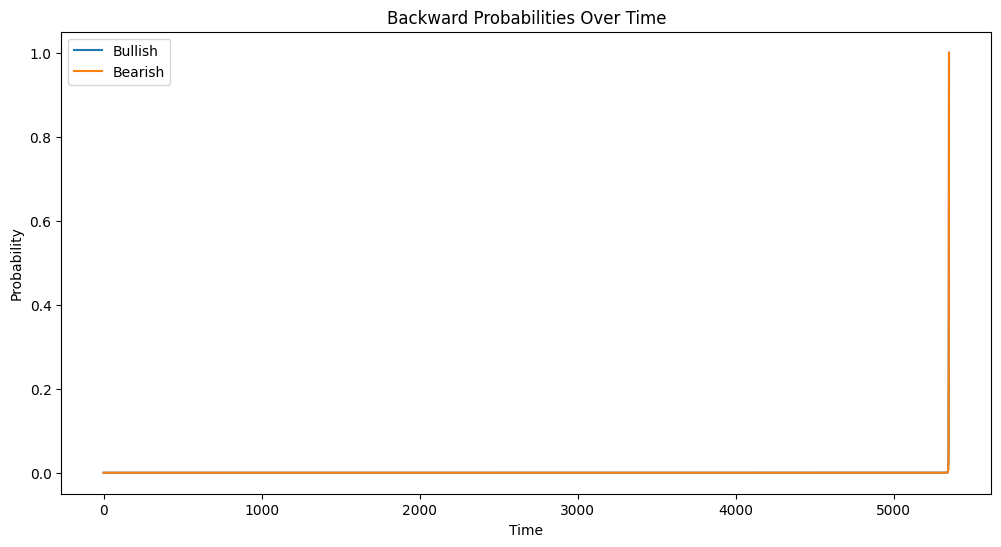

In [5]:
def backward_algorithm(observations, A, B):
    T = len(observations)
    beta = np.zeros((T, N))
    
    # Initialize last step
    beta[-1, :] = 1
    
    # Iterate backward through the observations
    for t in range(T-2, -1, -1):
        obs_idx_next = unique_states.index(observations[t+1])
        for i in range(N):
            beta[t, i] = np.sum(A[i, :] * B[:, obs_idx_next] * beta[t+1, :])
    
    return beta

# Run backward algorithm
beta = backward_algorithm(states, A, B)

# Plot the backward probabilities
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(beta[:, i], label=f'{hidden_states[i]}')
plt.title('Backward Probabilities Over Time')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

# Viterbi Algorithm

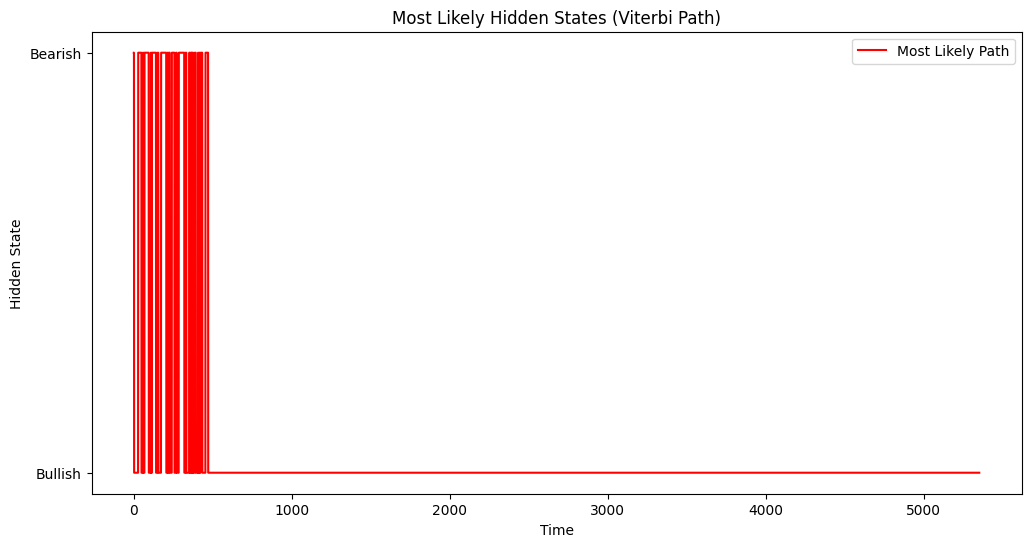

In [6]:
def viterbi_algorithm(observations, pi, A, B):
    T = len(observations)
    delta = np.zeros((T, N))
    psi = np.zeros((T, N), dtype=int)
    
    # Initialize
    obs_idx = unique_states.index(observations[0])
    delta[0, :] = pi * B[:, obs_idx]
    
    # Recursion
    for t in range(1, T):
        obs_idx = unique_states.index(observations[t])
        for j in range(N):
            delta[t, j] = np.max(delta[t-1, :] * A[:, j]) * B[j, obs_idx]
            psi[t, j] = np.argmax(delta[t-1, :] * A[:, j])
    
    # Backtracking
    path = np.zeros(T, dtype=int)
    path[-1] = np.argmax(delta[-1, :])
    for t in range(T-2, -1, -1):
        path[t] = psi[t+1, path[t+1]]
    
    return path, delta

# Run Viterbi algorithm
path, delta = viterbi_algorithm(states, pi, A, B)

# Plot the Viterbi path
plt.figure(figsize=(12, 6))
plt.plot(path, 'r-', label='Most Likely Path')
plt.yticks([0, 1], hidden_states)
plt.title('Most Likely Hidden States (Viterbi Path)')
plt.xlabel('Time')
plt.ylabel('Hidden State')
plt.legend()
plt.show()

## Trellis Diagram for Forward Algorithm

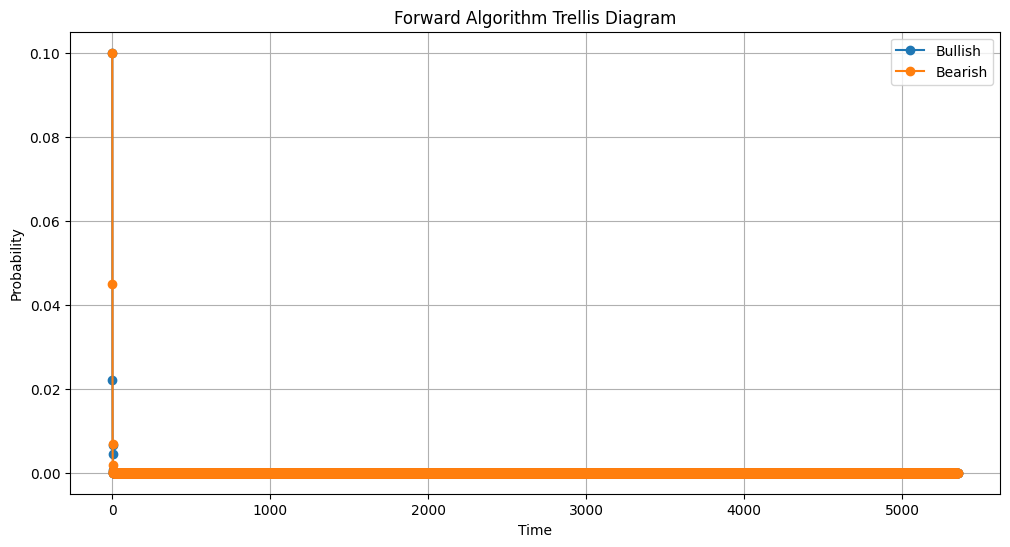

In [7]:
def plot_trellis(prob_matrix, title):
    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(prob_matrix[:, i], 'o-', label=f'{hidden_states[i]}')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_trellis(alpha, 'Forward Algorithm Trellis Diagram')

# Trellis Diagram for Viterbi Algorithm

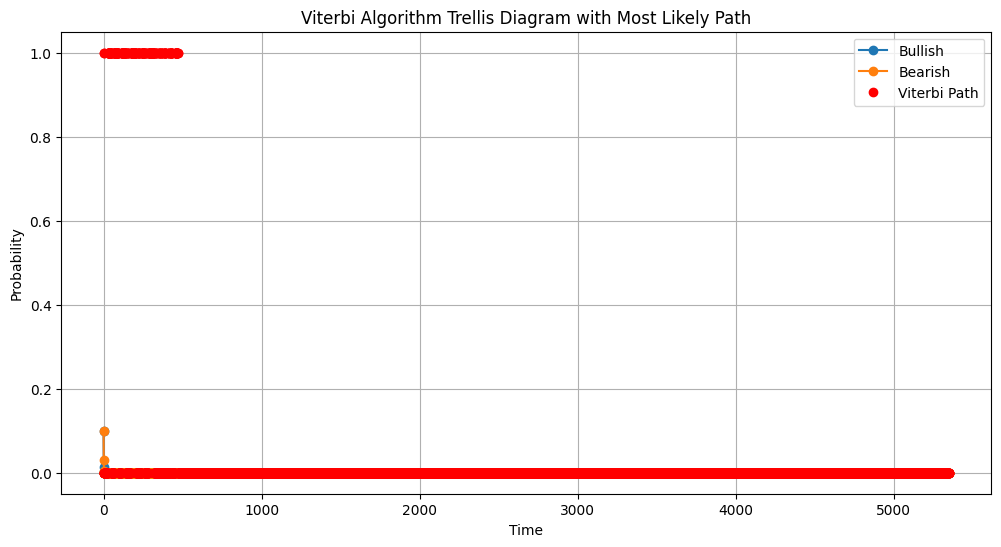

In [8]:
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(delta[:, i], 'o-', label=f'{hidden_states[i]}')
plt.plot(path, 'ro', label='Viterbi Path')
plt.title('Viterbi Algorithm Trellis Diagram with Most Likely Path')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

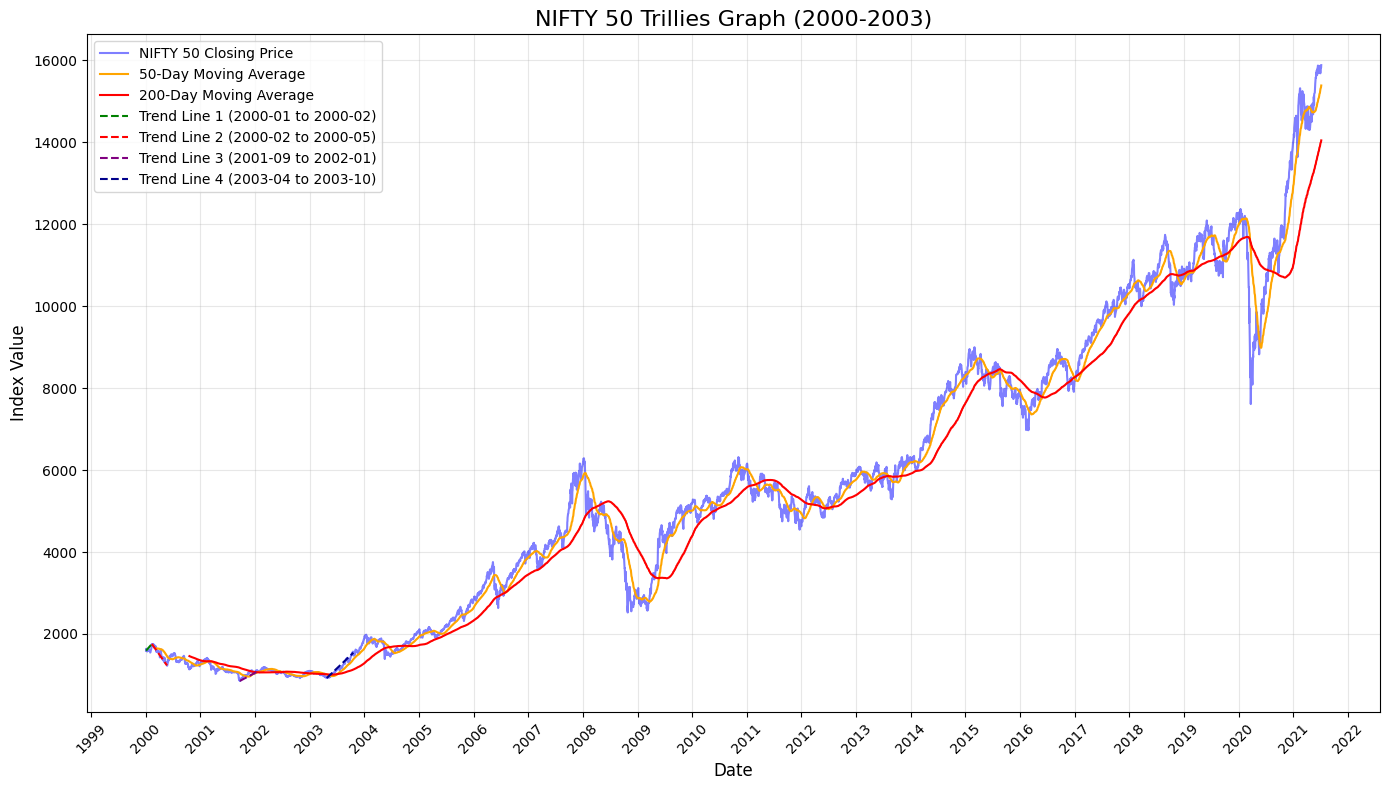

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the data
df = pd.read_csv('NIFTY 50.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Calculate moving averages
df['50_MA'] = df['Close'].rolling(window=50).mean()
df['200_MA'] = df['Close'].rolling(window=200).mean()

# Create the figure
plt.figure(figsize=(14, 8))

# Plot the closing price
plt.plot(df.index, df['Close'], label='NIFTY 50 Closing Price', color='blue', alpha=0.5)

# Plot the moving averages
plt.plot(df.index, df['50_MA'], label='50-Day Moving Average', color='orange', linewidth=1.5)
plt.plot(df.index, df['200_MA'], label='200-Day Moving Average', color='red', linewidth=1.5)

# Add trend lines - let's identify key support/resistance levels
# We'll manually identify some key points for trend lines
key_dates = [
    ('2000-01-03', '2000-02-11'),  # Early uptrend
    ('2000-02-11', '2000-05-22'),  # Downtrend
    ('2001-09-21', '2002-01-22'),  # Recovery attempt
    ('2003-04-25', '2003-10-20')   # Strong uptrend
]

colors = ['green', 'red', 'purple', 'darkblue']
for i, (start, end) in enumerate(key_dates):
    x = [pd.to_datetime(start), pd.to_datetime(end)]
    y = [df.loc[start, 'Close'], df.loc[end, 'Close']]
    plt.plot(x, y, color=colors[i], linestyle='--', linewidth=1.5, 
             label=f'Trend Line {i+1} ({start[:7]} to {end[:7]})')

# Formatting
plt.title('NIFTY 50 Trillies Graph (2000-2003)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Index Value', fontsize=12)
plt.grid(True, alpha=0.3)

# Format x-axis to show years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(loc='upper left', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# https://github.com/nwams/Hidden_Markov_Model-in-PyTorch/blob/master/Hidden%20Markov%20Models%20in%20PyTorch.ipynb